# Setup

In [1]:
# Import our plotting package from matplotlib
import matplotlib.pyplot as plt

# Specify that all plots will happen inline & in high resolution
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

# Import pandas for working with databases
import pandas as pd

# Import numpy below
import numpy as np

The Allen Institute has compiled a set of code and tools called a **Software Development Kit** (SDK). We need to make sure that you have this installed in your environment.

See [Technical Notes](#technical) at the end of this notebook for more information about working with the AllenSDK.

<div class="alert alert-success"><b>Task</b>: Run the cell below. If you receive an error, there are additional instructions on how to install the SDK locally <a href="https://allensdk.readthedocs.io/en/latest/install.html">here</a>.</div>

In [2]:
# This will ensure that the AllenSDK is installed.
try:
    import allensdk
    if allensdk.__version__ == '2.2.0':
        print('allensdk version ' + allensdk.__version__ + ' already installed')
    else:
        print('allensdk installed with an older version. some features may not work.')
except ImportError as e:
    !pip install allensdk

allensdk version 2.2.0 already installed


Now that we have the allensdk installed, we can `import` the CellTypesCache module. This module provides tools to allow us to get information from the Cell Types database. 

The CellTypesCache that we're importing provides tools to allow us to get information from the cell types database. We're giving it a **manifest** filename as well. CellTypesCache will create this manifest file, which contains metadata about the cache. If you want, you can look in the cell_types folder in your code directory and take a look at the file.

<div class="alert alert-success"><b>Task</b>: Run the cell below.</div>

In [3]:
#Import the "CellTypesCache" and "CellTypesApi" from the AllenSDK core package
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi


#Initialize the cache as 'ctc' (cell types cache)
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

print('CellTypesCache imported.')

CellTypesCache imported.


In [4]:
# Let's now get all of the electrophysiology data for the mouse and human cells, separately.

# Get the ephys features make a dataframe out of it
ephys_features = ctc.get_ephys_features()
ephys_features_df = pd.DataFrame.from_records(ephys_features)

# grab mouse data and merge with dataframe
mouse_df = pd.DataFrame(ctc.get_cells(species=[CellTypesApi.MOUSE]))
mouse_ephys_df = pd.merge(mouse_df,ephys_features_df,left_on='id',right_on='specimen_id',how='left')

# grab human data and merge with dataframe
human_df = pd.DataFrame(ctc.get_cells(species=[CellTypesApi.HUMAN]))
human_ephys_df = pd.merge(human_df,ephys_features_df,left_on='id',right_on='specimen_id',how='left')

# Show the first five rows of the human dataframe
human_ephys_df.head()

,reporter_status,cell_soma_location,species,id_x,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
0,None,"[273.0, 354.0, 216.0]",Homo Sapiens,525011903,H16.03.003.01.14.02,3,12113,FroL,,spiny,...,4.134987,1.375253,-53.968754,-59.510420,-71.197919,2.895461,2.559876,3.099787,-88.843758,-70.561035
1,None,"[69.0, 254.0, 96.0]",Homo Sapiens,528642047,H16.06.009.01.02.06.05,5,12141,MTG,,aspiny,...,NaN,1.051160,-67.468758,NaN,-70.875002,1.891881,NaN,1.989616,-101.000000,-69.209610
2,None,"[322.0, 255.0, 92.0]",Homo Sapiens,537256313,H16.03.006.01.05.02,4,12141,MTG,,spiny,...,5.694547,1.389900,-52.125004,-51.520836,-72.900002,3.121182,3.464528,3.054681,-87.531250,-72.628105
3,None,"[79.0, 273.0, 91.0]",Homo Sapiens,519832676,H16.03.001.01.09.01,3,12141,MTG,,spiny,...,9.962780,1.211020,-53.875004,-52.416668,-73.693753,4.574865,3.817988,4.980603,-84.218758,-72.547661
4,None,"[66.0, 220.0, 105.0]",Homo Sapiens,596020931,H17.06.009.11.04.02,4,12141,MTG,,aspiny,...,14.667340,1.336668,-63.593754,-63.239583,-75.518753,1.452890,1.441754,1.556087,-82.531250,-74.260269


# Get all the good stuff out of the dataset

In [ ]:
df = mouse_ephys_df

cell_surface_area = []
dendrite_type = []
input_resistance = []
tau = []
rheobase = []

for i in range(len(df)):
    this_cell = df['specimen_id'][i]
    if df['reconstruction_type'][i] == 'full':
        try:
            morphology = ctc.get_reconstruction(this_cell) 
            this_cell_radius = morphology.soma['radius']        
            cell_surface_area.append(4*np.pi*this_cell_radius*this_cell_radius)
            input_resistance.append(df['input_resistance_mohm'][i])
            tau.append(df['tau'][i])
            dendrite_type.append(df['dendrite_type'][i])
            
            # All of this to get the rheobase.
            rheobase_sweep_number = df['rheobase_sweep_number'][i]
            this_data = ctc.get_ephys_data(this_cell)
            rheo_sweep_meta = this_data.get_sweep_metadata(rheobase_sweep_number)
            rheobase.append(rheo_sweep_meta['aibs_stimulus_amplitude_pa'])
            
        except:
            pass

2020-09-30 15:24:21,823 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/614430804
2020-09-30 15:24:22,534 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657593282
2020-09-30 15:24:30,980 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/596793165
2020-09-30 15:24:32,051 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657593515
2020-09-30 15:24:46,637 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/610885976
2020-09-30 15:24:47,092 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657593464


In [44]:
# Get organized
fields = ['cell_surface_area','dendrite_type','rheobase','input_resistance','tau']
dataset = pd.DataFrame(list(zip(cell_surface_area,dendrite_type,rheobase,input_resistance,tau)),columns=fields)
dataset.head()

,cell_surface_area,dendrite_type,rheobase,input_resistance,tau
0,497.493364,spiny,129.999997,66.745424,50.049031
1,803.463769,aspiny,210.000003,126.099720,7.177321
2,294.496426,spiny,129.999997,310.081920,14.055187
3,590.989132,aspiny,69.999999,208.228560,18.539072
4,886.070983,aspiny,289.999996,139.217248,5.725947


In [46]:
dataset.to_csv('mouse_cell_metrics.csv')

',cell_surface_area,dendrite_type,rheobase,input_resistance,tau\n0,497.4933637737075,spiny,129.99999687846,66.745424,50.0490308584905\n1,803.4637689271481,aspiny,210.00000349769,126.09971999999999,7.1773210949830695\n2,294.49642649764985,spiny,129.99999687846,310.08192,14.0551868750163\n3,590.9891320541069,aspiny,69.9999988529321,208.22856000000002,18.539071801402898\n4,886.0709826560285,aspiny,289.999996239132,139.217248,5.725947148951009\n5,441.775944334967,spiny,129.99999687846,117.16936000000001,36.3162163557091\n6,350.7683562662959,spiny,50.0000006675716,234.6812,28.720737142611604\n7,985.8984550005495,spiny,190.000001842883,70.14132,20.7504039518502\n8,631.9014221376159,spiny,69.9999988529321,109.75153600000002,26.8857603438525\n9,582.2316962313613,aspiny,149.999998533268,122.644168,13.2589154509282\n10,333.990872588279,aspiny,9.99999996004197,464.684576,14.3873486560622\n11,1079.026102386544,spiny,329.999999548747,41.254088,15.361736567964098\n12,435.7317664959879,sparsely spiny

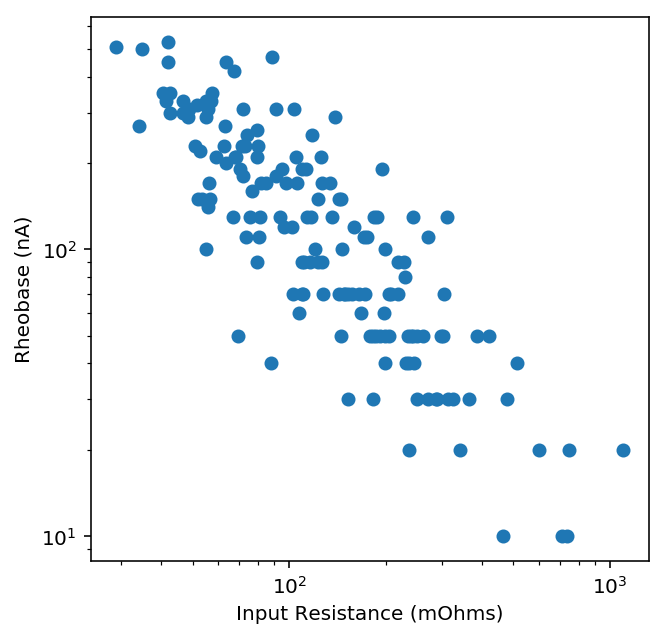

In [42]:
# Plot an individual comparison on a log scale

fig = plt.figure(figsize=(5,5))

plt.scatter(input_resistance,rheobase)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Input Resistance (mOhms)')
plt.ylabel('Rheobase (nA)')

plt.show()